Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from itertools import groupby
import re


Preprocess the data: We define a target length, that all our sequences should have. We choose something in the range of 7-12 since alpha helices and beta sheets often have that many residues. 

We get rid of non-standard-aa sequences,we one-hot-encode the amino acid sequences and split the data according to the labels and then only take sequences of the target length

In [2]:


class Preprocessing:
    def __init__(self, target_length, secondary_type = 'sst3'):
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        self.mapping_sst3 = {'C': 0, 'H': 1, 'E': 2}
        self.mapping_sst8 = {'C': 0, 'H': 1, 'E': 2, 'B': 3, 'G': 4, 'I':5, 'T':6, 'S':7}
        self.target_length = target_length
        self.secondary_type = secondary_type
        self.sequences = None
        self.labels = None
        self.lengths = None

    def one_hot_encode(self, sequence):
        # Create a tensor for the sequence where each amino acid is replaced by its index
        indices = torch.tensor([self.amino_acids.index(aa) for aa in sequence], dtype=torch.long)
        # One-hot encode
        return torch.nn.functional.one_hot(indices, num_classes=len(self.amino_acids)).type(torch.float)

    def process_labels(self, label):
        # Convert labels to indices
        if self.secondary_type == 'sst3':
            return torch.tensor([self.mapping_sst3[char] for char in label], dtype=torch.long)
        elif self.secondary_type == 'sst8':
            return torch.tensor([self.mapping_sst8[char] for char in label])
    
    def parser(self,labels, sequences):

        #when no key is provided to the groupby function, the labels itself are the key, "_" is representing the key and g is the list consisting of the same character
        categories = [''.join(g) for _, g in groupby(labels)]

        #perform those splits on the sequences
        splits = []
        corresponding_labels = []
        start = 0
        if categories:
            for category in categories:
                length = len(category)
                split = sequences[start:start+length]
                if len(split) == self.target_length:
                    splits.append(split)
                    corresponding_labels.append(category[0]) #only return the first label value
                    break #troubleshooting, to make sure that only one sequence is taken per string, otherwise there will be a mismatch (to be fixed)
    
                start += length
        
    
        return splits, corresponding_labels


    def preprocess_data(self, filepath, num_sequences=None):
        data = pd.read_csv(filepath)
        filtered_data = data[data['has_nonstd_aa'] == False]

        if num_sequences:
            filtered_data = filtered_data.sample(n = num_sequences)
            #filtered_data = filtered_data[:num_sequences]

        # Initialize lists for sequences and labels
        labels = []
        sequences = []
        for index1, lbl in enumerate(filtered_data[self.secondary_type]):
            for index2, seq in enumerate(filtered_data['seq']):
                if index1 == index2:
                    sequence, label = self.parser(lbl, seq)
                    if sequence:  # Check if split is not empty
                        sequences.extend(sequence)  # Append split to sequences list
                        labels.append(label[0]) #one label per sequence
        # print(labels)
        # print(len(sequences), len(labels))
        sequence_tensors = [self.one_hot_encode(seq) for seq in sequences]
        sequence_tensors = torch.stack(sequence_tensors).squeeze(0)
        label_tensors = self.process_labels(labels)



        #not necessary anymore at the moment
        # Padding sequences and labels
        # seq_lengths = torch.tensor([len(seq) for seq in sequence_tensors])
        # seq_tensor = torch.nn.utils.rnn.pad_sequence(sequence_tensors, batch_first=True, padding_value=0)
        # label_tensor = torch.nn.utils.rnn.pad_sequence(label_tensors, batch_first=True, padding_value=-1)  # Use -1 for label padding

        # Sort by sequence length in descending order for pack_padded_sequence
        #lengths, perm_idx = seq_lengths.sort(0, descending=True)
        #seq_tensor = seq_tensor[perm_idx]
        #label_tensor = label_tensor[perm_idx]


        self.sequences = sequence_tensors
        self.labels = label_tensors
        #self.lengths = lengths
        
        
        return sequence_tensors, label_tensors
    


In [3]:

# class Model(nn.Module):
#     def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
#         super(Model,self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim

#         #the problem problem lies in the lstm or in the pad_packed_sequence, after that there is a dimension mismatch
#         self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
    
#     def forward(self, x,lengths):
#         print(f'before padcking {x.size()}')
#         packed_x = pack_padded_sequence(x,lengths, batch_first=True, enforce_sorted=True)
#         packed_output, (hn,cn) = self.lstm(packed_x)
#         assert packed_x.data.size(0) == packed_output.data.size(0)
#         #this is still true, no assertion error
#         #so problem must lie in pad_packed_sequence
#         output, _ = pad_packed_sequence(packed_output, batch_first=True)
#         print(f"after padding:{output.size()}")
#         out = self.fc(output)
#         return out

        

# class AminoAcidDataset(Dataset):
#     def __init__(self, sequences, labels):
#         self.sequences = sequences 
#         self.labels = labels        # Corresponding labels or targets

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         return self.sequences[idx], self.labels[idx]


Now we run our preprocessing, at initialization we choose a target length. At the preprocessing step, we choose how many sequences in our dataset we want to process (because of time reasons)

In [4]:
#set num_sequences to False if you want all of them

secondary_output_number = 3 #chanege this together with secondary_type 

preprocessor = Preprocessing(target_length= 6, secondary_type = 'sst3')
path = '/Users/mcopet/Library/Mobile Documents/com~apple~CloudDocs/University/ETH/Semester2/CompBio/Project/2018-06-06-ss.cleaned.csv'
sequence_tensors, label_tensors = preprocessor.preprocess_data(path, num_sequences= 40000)

print(sequence_tensors. shape)
print(label_tensors.shape) #correct shapes


torch.Size([34222, 6, 20])
torch.Size([34222])


We define our model and our dataset. As model we choose a LSTM.

In [5]:

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        out = self.fc(output[:, -1, :])  # Take the last output of the LSTM sequence
        return out

class AminoAcidDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences 
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


We split our dataset into training, validation and test.

In [6]:
total = len(sequence_tensors)
train_size = int(0.6 * total)  # 60% of data for training
val_size = int(0.2 * total)    # 20% of data for validation
test_size = total - train_size - val_size  # Remaining 20% of data for testing

indices = torch.randperm(total).tolist()

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_sequences = sequence_tensors[train_indices]
train_labels = label_tensors[train_indices]

val_sequences = sequence_tensors[val_indices]
val_labels = label_tensors[val_indices]

test_sequences = sequence_tensors[test_indices]
test_labels = label_tensors[test_indices]


In [7]:

#lengths = torch.tensor([len(seq) for seq in sequence_tensors])
dataset = AminoAcidDataset(sequence_tensors, label_tensors)
loader = DataLoader(dataset, batch_size = 1000, shuffle = False)
train_dataset = AminoAcidDataset(train_sequences,train_labels)
val_dataset = AminoAcidDataset(val_sequences, val_labels)
test_dataset = AminoAcidDataset(test_sequences, test_labels)
trainloader = DataLoader(train_dataset, batch_size = 100, shuffle = True)
valloader = DataLoader(val_dataset, batch_size = 100, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 100)
#pack_padded_sequence(padded_sequences,...)



Define the model, loss function and optimizer. We use Adam optimizer and the crossentropy loss for multiclass classification

In [12]:
#Define the model, secondary_type (for output dimension), loss function and optimizer
model = Model(input_dim = 20, hidden_dim =140 , layer_dim = 6, output_dim = secondary_output_number)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
#device = ("mps" if torch.backends.mps.is_available() else "cpu")
#model.to(device)


Training and validation step

In [13]:

# Set the number of epochs
num_epochs = 200

# Initialize lists to monitor loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Iterate over epochs
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_samples = 0
    
    # Training phase
    for sequences, labels in trainloader:
        optimizer.zero_grad()
        sequences = sequences.float()
        
        # Forward pass
        outputs = model(sequences)
        outputs_flat = outputs.view(-1, secondary_output_number)
        labels_flat = labels.view(-1)
        
        # Calculate loss
        loss = criterion(outputs_flat, labels_flat)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item() * sequences.size(0)
        
        # Calculate total correct predictions
        _, predicted = torch.max(outputs_flat, 1)
        total_correct += (predicted == labels_flat).sum().item()
        total_samples += labels_flat.size(0)
    
    # Average loss for this epoch
    epoch_loss /= len(trainloader.dataset)
    train_losses.append(epoch_loss)

    # Calculate training accuracy
    train_accuracy = total_correct / total_samples
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for sequences, labels in valloader:
            sequences = sequences.float()
            outputs = model(sequences)
            outputs_flat = outputs.view(-1, secondary_output_number)
            labels_flat = labels.view(-1)
            
            # Calculate validation loss
            val_loss += criterion(outputs_flat, labels_flat).item() * sequences.size(0)
            
            # Calculate total correct predictions
            _, predicted = torch.max(outputs_flat, 1)
            val_correct += (predicted == labels_flat).sum().item()
            val_total += labels_flat.size(0)
    
    # Average validation loss for this epoch
    val_loss /= len(valloader.dataset)
    val_losses.append(val_loss)
    
    # Calculate validation accuracy
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')




Epoch [1/200], Training Loss: 1.0099, Training Accuracy: 0.4917, Validation Loss: 0.9823, Validation Accuracy: 0.4921
Epoch [2/200], Training Loss: 0.8755, Training Accuracy: 0.5979, Validation Loss: 0.7335, Validation Accuracy: 0.7234
Epoch [3/200], Training Loss: 0.6576, Training Accuracy: 0.7443, Validation Loss: 0.6173, Validation Accuracy: 0.7586
Epoch [4/200], Training Loss: 0.6047, Training Accuracy: 0.7623, Validation Loss: 0.6020, Validation Accuracy: 0.7633
Epoch [5/200], Training Loss: 0.5918, Training Accuracy: 0.7653, Validation Loss: 0.5903, Validation Accuracy: 0.7702
Epoch [6/200], Training Loss: 0.5843, Training Accuracy: 0.7701, Validation Loss: 0.5885, Validation Accuracy: 0.7652
Epoch [7/200], Training Loss: 0.5747, Training Accuracy: 0.7753, Validation Loss: 0.5891, Validation Accuracy: 0.7674
Epoch [8/200], Training Loss: 0.5707, Training Accuracy: 0.7772, Validation Loss: 0.5765, Validation Accuracy: 0.7721
Epoch [9/200], Training Loss: 0.5648, Training Accuracy:

KeyboardInterrupt: 

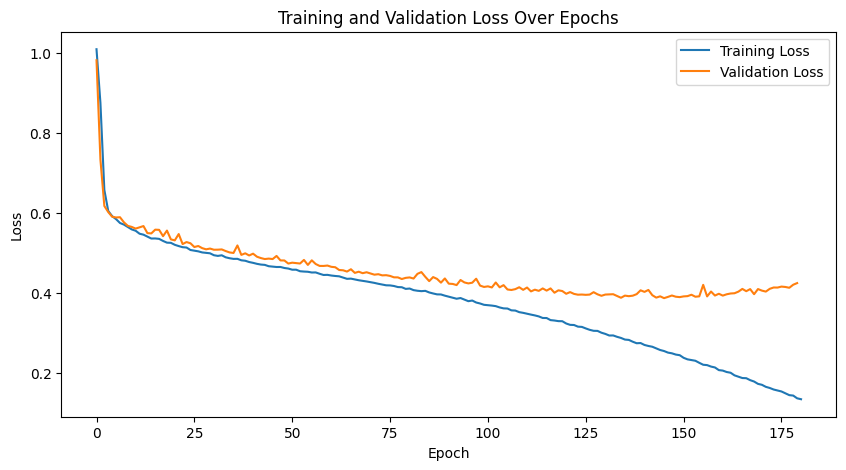

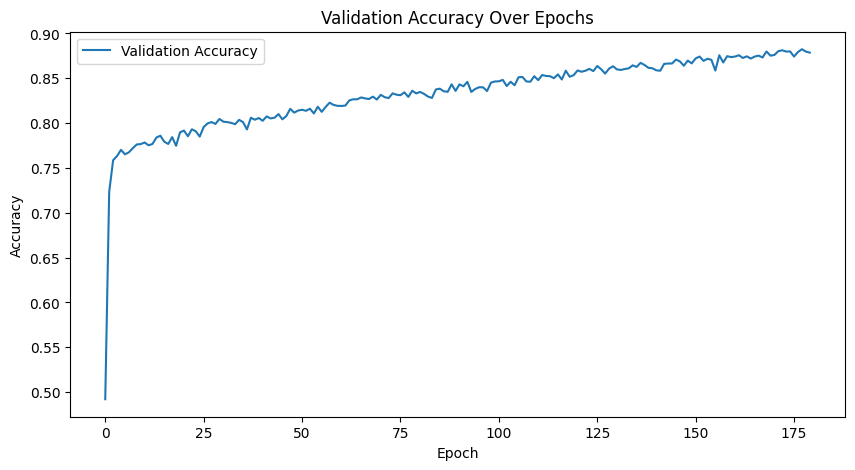

In [15]:

# Plotting the training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

Now we evaluate on the Test-Set

In [16]:
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for sequences, labels in testloader:
            outputs = model(sequences)
            outputs_flat = outputs.view(-1, 3)
            labels_flat = labels.view(-1)
                
            # Calculate validation loss
            test_loss += criterion(outputs_flat, labels_flat).item() * sequences.size(0)
            
            # Calculate total correct predictions
            _, predicted = torch.max(outputs_flat, 1)
            test_correct += (predicted == labels_flat).sum().item()
            test_total += labels_flat.size(0)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.8799123447772096


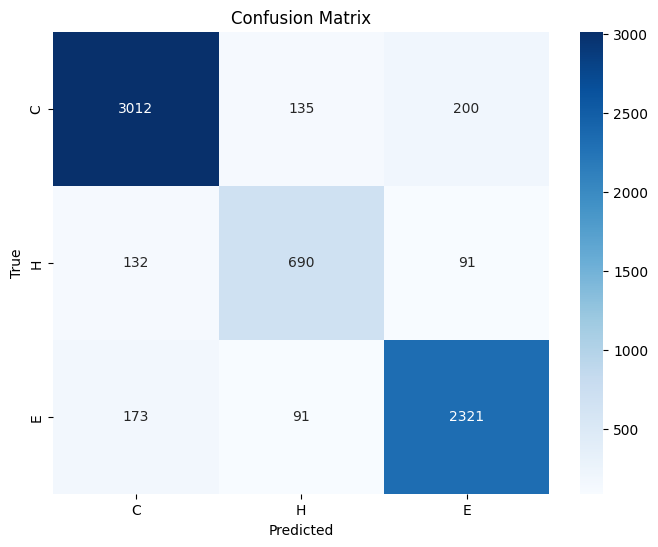

In [17]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues", xticklabels= ['C', 'H', 'E'], yticklabels = ['C', 'H', 'E'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

PART 2 OF THE PROJECT: Secondary structure prediction using Hidden Markov Models (HMM)

In [18]:
from hmmlearn import hmm
from sklearn.model_selection import train_test_split


Preprocess data again, but this time converting to integers, rather than one-hot-encoding them. Also we convert to list instead of tensors.

In [27]:

class Preprocessing:
    def __init__(self, target_length, secondary_type='sst3'):
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        self.mapping_sst3 = {'C': 0, 'H': 1, 'E': 2}
        self.mapping_sst8 = {'C': 0, 'H': 1, 'E': 2, 'B': 3, 'G': 4, 'I':5, 'T':6, 'S':7}
        self.target_length = target_length
        self.secondary_type = secondary_type
        self.sequences = None
        self.labels = None
        self.lengths = None

    def encode_sequence(self, sequence):
        # Convert the sequence to indices
        return np.array([self.amino_acids.index(aa) for aa in sequence], dtype=int)

    def process_labels(self, label):
        # Convert labels to indices
        if self.secondary_type == 'sst3':
            return np.array([self.mapping_sst3[char] for char in label])
        elif self.secondary_type == 'sst8':
            return np.array([self.mapping_sst8[char] for char in label])
    
    def parser(self, labels, sequences):
        # Group by consecutive labels
        categories = [''.join(g) for _, g in groupby(labels)]
        # Perform splits on the sequences
        splits = []
        corresponding_labels = []
        start = 0
        for category in categories:
            length = len(category)
            split = sequences[start:start+length]
            if len(split) == self.target_length:
                splits.append(split)
                corresponding_labels.append(category[0])
                break  # Ensure only one sequence per label
            start += length
        return splits, corresponding_labels

    def preprocess_data(self, filepath, num_sequences=None):

        data = pd.read_csv(filepath)
        filtered_data = data[data['has_nonstd_aa'] == False]

        if num_sequences:
           filtered_data = filtered_data.sample(n = num_sequences)
            #filtered_data = filtered_data.iloc[:num_sequences]

        labels = []
        sequences = []
        # Iterate over each sequence and corresponding label
        for lbl, seq in zip(filtered_data[self.secondary_type], filtered_data['seq']):
            sequence, label = self.parser(lbl, seq)
            if sequence:
                sequences.extend(sequence)
                labels.extend(label)  # Store labels, expecting a single label per sequence

        # Convert sequences to index arrays
        sequence_arrays = [self.encode_sequence(seq) for seq in sequences]
        label_arrays = self.process_labels(labels)  # Convert labels to index format
        self.sequences = sequence_arrays
        self.labels = label_arrays
        
        return sequence_arrays, label_arrays


Process data and split into train and test. Note that we only need our training labels to split the data into 3 separate lists

In [29]:
preprocessor = Preprocessing(target_length= 8, secondary_type = 'sst3')
path = '/Users/mcopet/Library/Mobile Documents/com~apple~CloudDocs/University/ETH/Semester2/CompBio/Project/2018-06-06-ss.cleaned.csv'
sequences, labels = preprocessor.preprocess_data(path, num_sequences= 30000)



Concatenate the training set into a single sequence and also calculate the length of each sequence (this would actually not be necessary, since we know that each sequence has the same length)

In [21]:

def converter(sequences, labels): 

    helix = []
    sheet = []
    other = []
    
    #append to the 3 different lists depending on the train label
    for index, sequence in enumerate(sequences):
        if labels[index] == 1:
            helix.append(sequence)
        elif labels[index] == 2:
            sheet.append(sequence)
        else: other.append(sequence)

    #create a list of sequence lenghts (it is always the same length, could also use: len(helix) * [len(helix[0])]

    len_helix = [len(seq) for seq in helix]
    len_sheet = [len(seq) for seq in sheet]
    len_other = [len(seq) for seq in other]

    #convert to one big sequence each
    helix = np.concatenate(helix).reshape(-1,1)
    sheet = np.concatenate(sheet).reshape(-1,1)
    other = np.concatenate(other).reshape(-1,1)
    return helix, len_helix, sheet, len_sheet, other, len_other



In [22]:

#the actual fitting of the model
def train_hmm(X, lengths):
    model = hmm.CategoricalHMM(n_components=3, n_iter=100)
    model.fit(X, lengths)
    return model

#converts the sequences, calls the fitting function, predicts new sequences using the log likelihood
def predict(sequences, labels):
    training, testing, train_labels, test_labels = train_test_split(sequences, labels, test_size = 0.2, random_state= 1)

    #create 3 separate lists and concatenate the lists into one long sequence each
    helix, len_helix, sheet, len_sheet, other, len_other = converter(training, train_labels)

    print(f'len helix: {len(helix)//8} len sheet:{len(sheet)//8} len other: {len(other)//8}')
    
    #fit the model for each sequence
    hmm_helix = train_hmm(helix, len_helix)
    hmm_sheet = train_hmm(sheet, len_sheet)
    hmm_coil = train_hmm(other, len_other)

    models = [hmm_helix, hmm_sheet, hmm_coil]
    prediction_labels = [1, 2, 0]

    #initialise to compute accuracy
    total = len(testing)
    correct = 0

    #calculate log likelihoods and take index of highest likelihood model
    for index, prediction in enumerate(testing):
        log_probs = [model.score(prediction.reshape(-1,1)) for model in models]
        
        best = np.argmax(log_probs)
        #print(log_probs)

        #compute if predictions match
        if(test_labels[index] == prediction_labels[best]):
            correct += 1
        #print(f"Predicted Label: {prediction_labels[best]}, Actual Label: {test_labels[index]}")
    print(f' Accuracy: {(correct/total)* 100}')



Run the fitting and prediction of the model

In [30]:
predict(sequences, labels)

len helix: 4298 len sheet:5379 len other: 7923
 Accuracy: 75.38636363636364


This already gives a good enough score. However, if time: manual implementation of the algorithms used












Everything below: Not relevant at the moment

In [ ]:
transition_matrix = np.random.random_sample(size = [3,3])
emission_matrix = np.random.random_sample(size = [20,3])
print(transition_matrix)

states = ['C', 'H', 'E']
mapping = {'C': 0, 'H': 1, 'E': 2}


NameError: name 'np' is not defined

In [ ]:
class HMM:
    def __init__(self, num_states, num_emissions):
        self.num_states = num_states
        self.num_emissions = num_emissions
        self.transition_matrix =  np.random.random_sample(size = [num_states,num_states])
        self.emission_matrix = np.random.random_sample(size = [num_emissions, num_states])
        self.initial_state_probs = np.random.random_sample(size = num_states)

    

Implement the Baum-Welch Algorithm (EM-Algorithm for HMMs)

In [ ]:
def forward(hmm, observations):
    num_states = hmm.num_states
    num_emissions = hmm.num_emissions
    T = len(observations)
    alpha = np.zeros((T, num_states))

    #initialization
    for i in range(num_states):
        alpha[0][i] = hmm.initial_state_probs[i] * hmm.emission_matrix[observations[0]][i]
    
    #recursion
    for t in range(1, T):
        for j in range(num_states):
            sum_alpha = sum(alpha[t-1][i] * hmm.transition_matrix[i][j] for i in range(num_states))
            alpha[t][j] = sum_alpha * hmm.emission_matrix[observations[t]][j]
    
    return alpha

def backward(hmm, observations):
    pass

In [ ]:
import numpy as np
from hmmlearn import hmm

# Define the states and possible emissions
states = ["Helix", "Sheet", "Coil"]
n_states = len(states)

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # Standard amino acids
n_features = len(amino_acids)

# Map amino acids to integers for processing
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Create a Multinomial HMM
model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=0.01)

# Initialize the transition probability matrix
model.transmat_ = np.array([
    [0.7, 0.15, 0.15],
    [0.15, 0.7, 0.15],
    [0.15, 0.15, 0.7]
])

# Initialize the emission probability matrix
model.emissionprob_ = np.full((n_states, n_features), 1 / n_features)

# Initialize the initial state probabilities
model.startprob_ = np.array([1 / n_states] * n_states)

# Example training data: Sequences of amino acids
# Convert sequences to a list of integers
train_seqs = [
    "ACDEFGHIKL",
    "QRSTVWYACD",
    "EFGHIKLMNP"
]
train_data = np.array([[aa_to_int[aa] for aa in seq] for seq in train_seqs])

# Reshape data appropriately
lengths = [len(seq) for seq in train_seqs]
train_data = np.concatenate(train_data).reshape(-1, 1)

# Fit the model using the Baum-Welch algorithm
model.fit(train_data, lengths)

# Show trained transition and emission matrices
print("Trained Transition Matrix:")
print(model.transmat_)
print("\nTrained Emission Matrix:")
print(model.emissionprob_)

# Predict the states for a new sequence
new_seq = np.array([aa_to_int[aa] for aa in "ACDEFGHIKL"]).reshape(-1, 1)
logprob, states = model.decode(new_seq, algorithm="viterbi")
print("\nLog Probability of Best State Sequence: ", logprob)
print("Predicted State Sequence: ", [states[i] for i in states])


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Trained Transition Matrix:
[[0.0058645  0.05541214 0.93872336]
 [0.25660292 0.48752007 0.25587701]
 [0.06538728 0.86603134 0.06858138]]

Trained Emission Matrix:
[[1.]
 [1.]
 [1.]]

Log Probability of Best State Sequence:  -4.857921817182164
Predicted State Sequence:  [0, 1, 2, 0, 1, 2, 0, 1, 2, 0]
